In [1]:
import anndata as ad
import logging
import pandas as pd
from typing import *
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import KFold

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

adata = ad.read_h5ad(
    "/aloy/home/ddalton/projects/scGPT_playground/data/pp_data-24-09-25-02/data.h5ad"
)

In [63]:
from sklearn.model_selection import train_test_split
import numpy as np


def get_stratified_test_split(obs: pd.DataFrame, n_splits=5) -> List[str]:
    """Get Test Split
    We will perform a split for those diseases which have more than one dataset.

    Ther MUST not be any data-leakage between the train and test set - no shared datasets between the two sets.

    Strategy:
        1. Check diseases w/ 5+ datasets
        2. Divide dataset into train and test w/ 4:1 ratio
        3. Assign train and test to the respective datasets

    """

    obs_copy = obs.copy(deep=True)

    # pre-process data
    obs_copy["combination"] = (
        obs_copy["celltype"].astype(str) + "_" + obs_copy["dataset_id"].astype(str)
    )

    logging.info(f"Columns in obs_copy {obs_copy.columns}")

    assert "combination" in obs_copy.columns, "combination column not created in obs"

    diseases_f1 = set()  # diseases filter 1

    # 1. Check diseases w/ 5+ datasets
    all_diseases = obs_copy["celltype"].unique()
    for diseases in all_diseases:
        QUERY = f'celltype == "{diseases}"'
        _df_query = obs_copy.query(QUERY)
        if len(_df_query["dataset_id"].unique()) >= 5:
            diseases_f1.add(diseases)

    logging.info(f"Number of diseases with 5+ datasets: {len(diseases_f1)}")

    # 2. Divide dataset into train and test w/ 4:1 ratio
    QUERY = "celltype in @diseases_f1"
    df_diseases_f1 = obs_copy.query(QUERY)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
    for i, (train_idx, test_idx) in enumerate(
        sgkf.split(
            X=df_diseases_f1["ids"],
            y=df_diseases_f1["celltype"],
            groups=df_diseases_f1["dataset_id"],
        )
    ):

        # get which disease & datasets are in the test
        df_diseases_f1_test = df_diseases_f1.iloc[test_idx]

        assert "combination" in obs_copy.columns, "combination column not found in obs"
        assert (
            "combination" in df_diseases_f1_test.columns
        ), "combination column not found in df_diseases_f1_test"

        # 3. Assign train and test labels
        obs_copy[f"test_split_{i+1}"] = (
            obs_copy["combination"].isin(df_diseases_f1_test["combination"]).astype(int)
        )

        logging.info(
            f"Nº of diseases in train split {i+1}: {obs_copy.iloc[train_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of diseases in test split {i+1}: {obs_copy.iloc[test_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in train split {i+1}: {obs_copy.iloc[train_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in test split {i+1}: {obs_copy.iloc[test_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of samples in train split {i+1}: {obs_copy.iloc[train_idx]['ids'].nunique()}"
        )

        logging.info(
            f"Nº of samples in test split {i+1}: {obs_copy.iloc[test_idx]['ids'].nunique()}"
        )

    obs_copy.drop(columns=["combination"], inplace=True)

    return obs_copy


def get_test_split(obs: pd.DataFrame, n_splits=5) -> List[str]:
    """Get Test Split
    We will perform a split for those diseases which have more than one dataset.

    Ther MUST not be any data-leakage between the train and test set - no shared datasets between the two sets.

    Strategy:
        1. Check diseases w/ 5+ datasets
        2. Divide dataset into train and test w/ 4:1 ratio
        3. Assign train and test to the respective datasets

    """

    obs_copy = obs.copy(deep=True)

    all_diseases = obs_copy["celltype"].unique()

    logging.info(f"Number of diseases: {len(all_diseases)}")

    # 2. Divide dataset into train and test w/ 4:1 ratio
    kf = KFold(n_splits=n_splits, shuffle=True)
    for i, (train_idx, test_idx) in enumerate(
        kf.split(
            X=obs_copy["ids"],
            y=obs_copy["celltype"],
        )
    ):

        mask = np.zeros(len(obs_copy), dtype=bool)
        mask[test_idx] = True

        # 3. Assign train and test labels
        obs_copy[f"test_split_{i+1}"] = mask

        logging.info(
            f"Nº of diseases in train split {i+1}: {obs_copy.iloc[train_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of diseases in test split {i+1}: {obs_copy.iloc[test_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in train split {i+1}: {obs_copy.iloc[train_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in test split {i+1}: {obs_copy.iloc[test_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of samples in train split {i+1}: {obs_copy.iloc[train_idx]['ids'].nunique()}"
        )

        logging.info(
            f"Nº of samples in test split {i+1}: {obs_copy.iloc[test_idx]['ids'].nunique()}"
        )

    return obs_copy


def get_test_split_common(obs: pd.DataFrame, n_splits=5) -> List[str]:
    """Get Test Split
    We will perform a split for those diseases which have more than one dataset.

    Ther MUST not be any data-leakage between the train and test set - no shared datasets between the two sets.

    Strategy:
        1. Check diseases w/ 5+ datasets
        2. Divide dataset into train and test w/ 4:1 ratio
        3. Assign train and test to the respective datasets

    """

    from sklearn.model_selection import StratifiedKFold

    obs_copy = obs.copy(deep=True)

    combined_labels = (
        adata.obs["celltype"].astype(str) + "_" + adata.obs["dataset_id"].astype(str)
    )

    combined_labels.unique()

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for i, (train_idx, test_idx) in enumerate(
        kf.split(X=adata.obs["ids"], y=combined_labels)
    ):

        mask = np.zeros(len(obs_copy), dtype=bool)
        mask[test_idx] = True

        # 3. Assign train and test labels
        obs_copy[f"test_split_{i+1}"] = mask

        logging.info(
            f"Nº of diseases in train split {i+1}: {obs_copy.iloc[train_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of diseases in test split {i+1}: {obs_copy.iloc[test_idx]['celltype'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in train split {i+1}: {obs_copy.iloc[train_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of datasets in test split {i+1}: {obs_copy.iloc[test_idx]['dataset_id'].nunique()}"
        )

        logging.info(
            f"Nº of samples in train split {i+1}: {obs_copy.iloc[train_idx]['ids'].nunique()}"
        )

        logging.info(
            f"Nº of samples in test split {i+1}: {obs_copy.iloc[test_idx]['ids'].nunique()}"
        )

    return obs_copy

In [62]:
df_obs = adata.obs


new_obs = get_stratified_test_split(obs=df_obs, n_splits=3)

new_obs = get_test_split(obs=df_obs, n_splits=3)

new_obs = get_test_split_common(obs=df_obs, n_splits=3)

2024-09-27 15:34:03,663 - Columns in obs_copy Index(['ids', 'dataset', 'dataset_id', 'batch', 'batch_id', 'dsaid', 'tissue',
       'n_genes', 'disease', 'celltype', 'disease_study', 'library',
       'test_split_1', 'test_split_2', 'test_split_3', 'combination'],
      dtype='object')
2024-09-27 15:34:03,682 - Number of diseases with 5+ datasets: 7
2024-09-27 15:34:03,722 - Nº of datasets in train split 1: 132
2024-09-27 15:34:03,724 - Nº of datasets in test split 1: 59
2024-09-27 15:34:03,727 - Nº of samples in train split 1: 7739
2024-09-27 15:34:03,728 - Nº of samples in test split 1: 3847
2024-09-27 15:34:03,732 - Nº of datasets in train split 2: 127
2024-09-27 15:34:03,733 - Nº of datasets in test split 2: 64
2024-09-27 15:34:03,735 - Nº of samples in train split 2: 7719
2024-09-27 15:34:03,736 - Nº of samples in test split 2: 3867
2024-09-27 15:34:03,739 - Nº of datasets in train split 3: 123
2024-09-27 15:34:03,740 - Nº of datasets in test split 3: 68
2024-09-27 15:34:03,741 - 

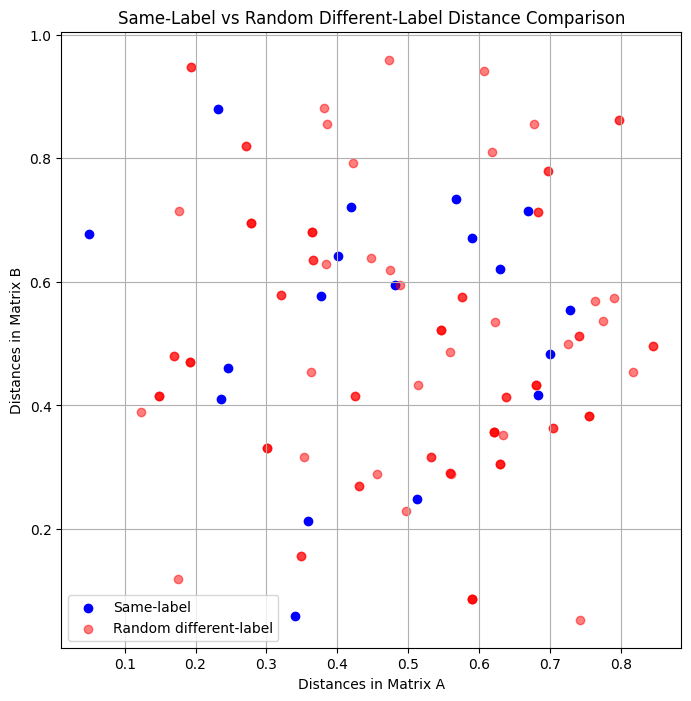

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random


def plot_distance_comparison(matrix_A, matrix_B, labels, num_random_samples=100):
    """
    Plots a comparison of pairwise distances from two matrices A and B for the same labels
    and random different label pairs.

    Parameters:
    - matrix_A: Pairwise distance matrix A (numpy array)
    - matrix_B: Pairwise distance matrix B (numpy array)
    - labels: List of labels corresponding to the matrix (must match dimensions of matrices)
    - num_random_samples: Number of random different-label samples to plot
    """
    same_label_distances_A = []
    same_label_distances_B = []

    random_label_distances_A = []
    random_label_distances_B = []

    # Create a mapping of labels to their indices
    label_to_indices = {}
    for i, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(i)

    # Plot same-label distances (e.g., A-A, B-B, etc.)
    for label, indices in label_to_indices.items():
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):  # Ensure unique pairs
                idx1, idx2 = indices[i], indices[j]
                same_label_distances_A.append(matrix_A[idx1, idx2])
                same_label_distances_B.append(matrix_B[idx1, idx2])

    # Random different-label distances (e.g., A-C, B-F, etc.)
    unique_labels = list(label_to_indices.keys())
    total_samples = len(labels)

    # Randomly sample different-label distances
    for _ in range(num_random_samples):
        while True:
            idx1, idx2 = random.sample(range(total_samples), 2)
            if labels[idx1] != labels[idx2]:  # Ensure different labels
                random_label_distances_A.append(matrix_A[idx1, idx2])
                random_label_distances_B.append(matrix_B[idx1, idx2])
                break

    # Create the plot
    plt.figure(figsize=(8, 8))

    # Plot same-label distances (main comparison)
    plt.scatter(
        same_label_distances_A,
        same_label_distances_B,
        label="Same-label",
        color="blue",
        marker="o",
    )

    # Plot random different-label distances (background)
    plt.scatter(
        random_label_distances_A,
        random_label_distances_B,
        label="Random different-label",
        color="red",
        alpha=0.5,
    )

    # Labels and legend
    plt.xlabel("Distances in Matrix A")
    plt.ylabel("Distances in Matrix B")
    plt.title("Same-Label vs Random Different-Label Distance Comparison")
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()


# Example usage (with dummy data for illustration)
labels = [
    "A",
    "A",
    "A",
    "A",
    "B",
    "B",
    "B",
    "C",
    "D",
    "E",
    "E",
    "E",
    "E",
    "F",
    "F",
    "F",
]

# Random distance matrices for illustration (replace with your actual distance matrices)
matrix_A = np.random.rand(len(labels), len(labels))
matrix_B = np.random.rand(len(labels), len(labels))

# Ensure symmetry, since these are pairwise distances
matrix_A = (matrix_A + matrix_A.T) / 2
matrix_B = (matrix_B + matrix_B.T) / 2

# Call the function to plot
plot_distance_comparison(matrix_A, matrix_B, labels)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data (replace with your actual data)
labels = ["A", "A", "B", "B", "B", "C", "D", "D", "E", "E", "F", "F"]
matrix_A = np.random.rand(len(labels), len(labels))
matrix_B = np.random.rand(len(labels), len(labels))


def get_pair_idxs(labels, same=True):
    n_labels = len(labels)
    output_idxs = list()
    output_labels = list()
    if same:
        for i in range(n_labels):
            for j in range(i + 1, n_labels):
                if labels[i] == labels[j]:
                    output_idxs.append([i, j])
                    output_labels.append(labels[i] + "-" + labels[j])
    else:
        for i in range(n_labels):
            for j in range(i + 1, n_labels):
                if labels[i] != labels[j]:
                    output_idxs.append([i, j])
                    output_labels.append(labels[i] + "-" + labels[j])

    output_idxs = np.array(output_idxs)
    output_labels = np.array(output_labels)

    return output_idxs, output_labels


same_idxs, same_labels = get_pair_idxs(labels, same=True)
diff_idxs, random_labels = get_pair_idxs(labels, same=False)

data_same_A = matrix_A[same_idxs[:, 0], same_idxs[:, 1]]
data_same_B = matrix_B[same_idxs[:, 0], same_idxs[:, 1]]

colormap = plt.cm.get_cmap(
    "gist_rainbow", len(set(same_labels))
)  # You can change "tab20" to any other colormap

plt.figure(figsize=(8, 8))

# Plot the same-label data points with different colors
for i, label in enumerate(set(same_labels)):
    data_idxs = same_labels == label

    x = data_same_A[data_idxs]
    y = data_same_B[data_idxs]

    # Combine all points into a 2D array for density estimation
    xy = np.vstack([x, y])
    density = gaussian_kde(xy)(xy)

    # Normalize density values to [0, 1] for coloring
    density_norm = (density - density.min()) / (density.max() - density.min())

    # Define a colormap for the scatter plot
    colormap = plt.cm.viridis

    plt.scatter(
        data_same_A[data_idxs],
        data_same_B[data_idxs],
        label=label,
        c=density_norm,  # Color by normalized density
        cmap=colormap,
        marker="o",
        s=30,
    )

# Choose up to 10 times the length of same_labels (or less, if random_labels is smaller)
num_samples = min(len(random_labels), 10 * len(same_labels))

# Randomly sample the specified number of indices
rand_data_idxs = random.sample(list(range(len(random_labels))), num_samples)

# Extract the data points to be plotted for random different-label comparisons
x = matrix_A[diff_idxs[rand_data_idxs, 0], diff_idxs[rand_data_idxs, 1]]
y = matrix_B[diff_idxs[rand_data_idxs, 0], diff_idxs[rand_data_idxs, 1]]

# Create a scatter plot for the random points, all colored grey
plt.scatter(
    x,
    y,
    label="Random",  # Label for the random points
    color="grey",  # Uniform grey color
    alpha=0.5,
    s=10,
)

# Add a legend combining all plots
plt.legend()

# Final plot settings
plt.xlabel("Matrix A")
plt.ylabel("Matrix B")
plt.title("Scatter Plot with Same-Label and Random Data Points")
plt.show()

/tmp/ipykernel_63626/4010672389.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

<Figure size 800x800 with 0 Axes>

In [ ]:
df_info_path = 

In [41]:
data_same_A[data_idxs]

array([0.90305065])

In [17]:
same_labels

array(['A-A', 'B-B', 'B-B', 'B-B', 'D-D', 'E-E', 'F-F'], dtype='<U3')

In [2]:
    unique_labels = np.unique(labels)
    
    same_label_distances_A = []
    same_label_distances_B = []
    
    random_label_distances_A = []
    random_label_distances_B = []
    
    # Plot same-label distances (A-A, B-B, C-C, etc.)
    for i, label in enumerate(unique_labels):
        same_label_distances_A.append(matrix_A[i, i])
        same_label_distances_B.append(matrix_B[i, i])

In [5]:
unique_labels

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [4]:
i

3

In [53]:
from sklearn.model_selection import StratifiedKFold

combined_labels = (
    adata.obs["celltype"].astype(str) + "_" + adata.obs["dataset_id"].astype(str)
)

combined_labels.unique()

kf = StratifiedKFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(
    kf.split(X=adata.obs["ids"], y=combined_labels)
):
    print(f"train_index: {len(train_index)}")
    print(f"test_index: {len(test_index)}")

    print(adata.obs.iloc[test_index]["dataset_id"].nunique())
    print(adata.obs.iloc[train_index]["dataset_id"].nunique())

train_index: 9268
test_index: 2318
190
191
train_index: 9269
test_index: 2317
190
191
train_index: 9269
test_index: 2317
191
191
train_index: 9269
test_index: 2317
188
191
train_index: 9269
test_index: 2317
191
191


/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [44]:
import os, pandas as pd

df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)

df_info = pd.read_csv(df_info_path)

In [60]:
library_stratergies = ["RNA-Seq", "Microarray"]

QUERY = f"library_strategy in @library_stratergies"
df_filtered = df_info.query(QUERY)

print(df_filtered.shape, df_info.shape)

n_datasets = list()
disease_names = list()
for disease in df_filtered["disease"].unique():
    df_query = df_filtered.query(f'disease == "{disease}"')
    if df_query["accession"].nunique() > 0:
        n_datasets.append(df_query["accession"].nunique())

(9978, 14) (10306, 14)


In [65]:
data_results = list()
for filter in range(1, 11):
    n_dis_count = len([x for x in n_datasets if x >= filter])
    data_results.append(
        {
            "Filter": f"Nº datasets ≥ {filter}",
            "Nº Diseases": n_dis_count,
        }
    )

df_results = pd.DataFrame(data_results)
print(df_results.set_index("Filter"))

                  Nº Diseases
Filter                       
Nº datasets ≥ 1          1799
Nº datasets ≥ 2           638
Nº datasets ≥ 3           380
Nº datasets ≥ 4           275
Nº datasets ≥ 5           218
Nº datasets ≥ 6           181
Nº datasets ≥ 7           154
Nº datasets ≥ 8           139
Nº datasets ≥ 9           119
Nº datasets ≥ 10          104


<Axes: ylabel='Density'>

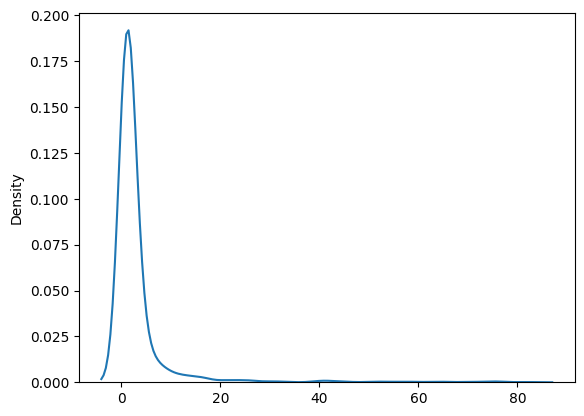

In [67]:
import seaborn as sns

sns.kdeplot(n_datasets, fill=True)

In [ ]:
df_counts = pd.DataFrame(n_datasets, columns=["n_datasets"])

In [48]:
df_info

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition,Control,Case
0,DSA00001,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021712,GSM7021715
1,DSA00002,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021713,GSM7021716
2,DSA00003,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021714,GSM7021717
3,DSA00004,GSE224022,GPL16791,1000,Retinoblastoma,C0035335,Retina,GEO,RNA-Seq,Homo sapiens,4|5,DO:A retinal cell cancer and malignant neoplas...,GSM7009973;GSM7009974;GSM7009976;GSM7009977,GSM7009978;GSM7009979;GSM7009980;GSM7009981;GS...
4,DSA00005,GSE126342,GPL11154,1000,Congenital Myotonic Dystrophy,C0410226,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,9|11,MONDO:An inherited progressive disorder affect...,GSM3596881;GSM3596882;GSM3596883;GSM3596884;GS...,GSM3596870;GSM3596871;GSM3596872;GSM3596873;GS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,DSA10302,GSE6008,GPL96,1000,Ovarian Tumor,C1140680,Ovary,GEO,Microarray,Homo sapiens,4|41,DO:A female reproductive organ cancer that is ...,Click to openGSM139476;GSM139477;GSM139478;GSM...,Click to openGSM139435;GSM139436;GSM139437;GSM...
10302,DSA10303,GSE6280,GPL96,758,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,GSM144461;GSM144462;GSM144463;GSM144472;GSM144...,GSM144464;GSM144465;GSM144466;GSM144467;GSM144...
10303,DSA10304,GSE6280,GPL97,337,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,GSM144481;GSM144482;GSM144483;GSM144492;GSM144...,GSM144484;GSM144485;GSM144486;GSM144487;GSM144...
10304,DSA10305,GSE6344,GPL96,1000,Clear Cell Ependymoma,C1384403,Kidney,GEO,Microarray,Homo sapiens,5|5,"EFO:A WHO grade II, slow growing tumor of chil...",GSM146778;GSM146780;GSM146782;GSM146784;GSM146786,GSM146779;GSM146781;GSM146783;GSM146785;GSM146787
